# Lab 5 - Topic-based Sentiment Analysis with a Real Dataset


---















In this session, we will build a model for topic-based sentiment analysis: detecting sentiment towards a topic (or target) which is not necessarily present in the text. We use a dataset from a recent public shared task: SemEval 2017 Task 4 subtask B. You can find the whole task description here: https://alt.qcri.org/semeval2017/task4/data/uploads/semeval2017-task4.pdf.

Semeval 2017 task4(subtask B) provides a tweet text dataset with topics.
Given a tweet and a topic, we need to classify the sentiment conveyed towards that topic on a  two-point scale:   POSITIVE vs. NEGATIVE.
Although it is still a binary classification task, this classifier needs to analyze the text and its topic. 

As before, we are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. You could modify the previous models to fit in the new task.

In [ ]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model
from keras.utils import plot_model


### Downloading and preprocessing data

Unlike the IMDB dataset we used in previous labs, which is included and preprocessed by Keras, the 
SemEval dataset we will be using here must be downloaded separately. The data is not balanced: the numbers of positive and negative instances are not equal, in either training or test set.


In [ ]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)

downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016devtest-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016dev-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016test-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016train-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2015test-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2015train-BD.tsv')

downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/gold/SemEval2017-task4-test.subtask-BD.english.txt')

with open('twitter-2016dev-BD.tsv', 'r') as f:
  dev_original = [l.strip().split('\t') for l in f.readlines()]
with open('SemEval2017-task4-test.subtask-BD.english.txt', 'r') as f:
  test_original = [l.strip().split('\t') for l in f.readlines()]
train_original = []
with open('twitter-2016train-BD.tsv', 'r') as f:
  train_original = [l.strip().split('\t') for l in f.readlines()]
with open('twitter-2016test-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines()])
with open('twitter-2016devtest-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines()])
with open('twitter-2015test-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines() if l.strip().split('\t')[2] in ['negative','positive']])
with open('twitter-2015train-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines() if l.strip().split('\t')[2] in ['negative','positive']])

print("Training entries: {}".format(len(train_original)))
print("Development entries: {}".format(len(dev_original)))
print("Testing entries: {}".format(len(test_original)))

Training entries: 17639
Development entries: 1325
Testing entries: 6185


We now can start playing around with the data, let’s first see some examples:

In [ ]:
print("ID \t TOPIC \t LABLE \t TWEET_TEXT")
print(train_original[0])
print(train_original[1])
print(train_original[2])
print(train_original[3])
print(train_original[4])

ID 	 TOPIC 	 LABLE 	 TWEET_TEXT
['628949369883000832', '@microsoft', 'negative', "dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon."]
['628976607420645377', '@microsoft', 'negative', "@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!"]
['629023169169518592', '@microsoft', 'negative', "I may be ignorant on this issue but... should we celebrate @Microsoft's parental leave changes? Doesn't the gender divide suggest... (1/2)"]
['629179223232479232', '@microsoft', 'negative', 'Thanks to @microsoft, I just may be switching over to @apple.']
['629226490152914944', '@microsoft', 'positive', 'Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft']


Build a vocabulary based on the training dataset. 

In [ ]:
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in train_original:
  topic_tokens = text_to_word_sequence(example[1])
  text_tokens = text_to_word_sequence(example[3])
  voc.extend(topic_tokens)
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))

32571
32575


According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the tweet text and topic words to word tokens and integers separately:


In [ ]:

x_train_tweet = []
x_train_topic = []
x_train_tweet_int = []
x_train_topic_int = []

for example in train_original:
  x_train_topic.append(text_to_word_sequence(example[1]))
  x_train_tweet.append(text_to_word_sequence(example[3]))
  x_train_tweet_int.append([word_index[x] for x in text_to_word_sequence(example[3])])
  x_train_topic_int.append([word_index[x] for x in text_to_word_sequence(example[1])])

x_dev_tweet = []
x_dev_topic = []
x_dev_tweet_int = []
x_dev_topic_int = []
for example in dev_original:
  word_list_tweet = []
  word_list_topic = []
  x_dev_topic.append(text_to_word_sequence(example[1]))
  x_dev_tweet.append(text_to_word_sequence(example[3]))
  for word in text_to_word_sequence(example[3]): 
    if word in word_index.keys():
      word_list_tweet.append(word_index[word])
    else:
      word_list_tweet.append(word_index["<UNK>"])
  x_dev_tweet_int.append(word_list_tweet)
  for word in text_to_word_sequence(example[1]):
    if word in word_index.keys():
      word_list_topic.append(word_index[word])
    else:
      word_list_topic.append(word_index["<UNK>"])
  x_dev_topic_int.append(word_list_topic)

x_test_tweet = []
x_test_topic = []
x_test_tweet_int = []
x_test_topic_int = []
for example in test_original:
  word_list_tweet = []
  word_list_topic = []
  x_test_topic.append(text_to_word_sequence(example[1]))
  x_test_tweet.append(text_to_word_sequence(example[3]))
  # x_test_tweet_int.append([word_index[x] for x in text_to_word_sequence(example[3])])
  for word in text_to_word_sequence(example[3]): 
    if word in word_index.keys():
      word_list_tweet.append(word_index[word])
    else:
      word_list_tweet.append(word_index["<UNK>"])
  x_test_tweet_int.append(word_list_tweet)
  # x_test_topic_int.append([word_index[x] for x in text_to_word_sequence(example[1])])
  for word in text_to_word_sequence(example[1]):
    if word in word_index.keys():
      word_list_topic.append(word_index[word])
    else:
      word_list_topic.append(word_index["<UNK>"])
  x_test_topic_int.append(word_list_topic)

# If use the previous word_index, you can get a print result like:
assert len(x_train_topic) == len(train_original)
assert len(x_train_topic) == len(x_train_topic_int)
assert len(x_test_topic) == len(test_original)
assert len(x_test_topic) == len(x_test_topic_int)
print("x_dev_tweet[0]:")
print(x_dev_tweet[0])
print("x_dev_topic[0]:")
print(x_dev_topic[0])
print("x_dev_tweet_int[0]:")
print(x_dev_tweet_int[0])
print("x_dev_topic_int[0]:")
print(x_dev_topic_int[0])

x_dev_tweet[0]:
['jay', 'z', 'joins', 'instagram', 'with', 'nostalgic', 'tribute', 'to', 'michael', 'jackson', 'jay', 'z', 'apparently', 'joined', 'instagram', 'on', 'saturday', 'and', 'http', 't', 'co', 'qj9i4ecvxy']
x_dev_topic[0]:
['michael', 'jackson']
x_dev_tweet_int[0]:
[18710, 17453, 26499, 16330, 24596, 19751, 15719, 15905, 28271, 26249, 18710, 17453, 1902, 26280, 16330, 25930, 30680, 18645, 13967, 13402, 2664, 2]
x_dev_topic_int[0]:
[28271, 26249]


**<i><font color ='darkblue'>For preprocessing tweets and topics separately, we have used the corresponding columns from train_original, dev_original and test_original. We have tokenised the text in tweets and tokens using text_to_word_sequence(). For converting each token in tweet and topic to corresponding integer, we use the word_index dictionary. For development and test set, if we encounter a token which is not  present in word_index, we consider it as an unknown word and use the integer for \<UNK> i.e 2.</font></i>**  

We use 1 to represent "positive" and 0 for "negative" and generate the "y" data similar to previous labs.

In [ ]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append(0)
    else:
      y.append(1)
  return y
  
y_train = label2int(train_original)
y_dev = label2int(dev_original)
y_test = label2int(test_original)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

0
0
0
0
1


Now we have almost done the data preprocessing. Unlike the previous lab, there are two x (tweet and topic) to input the model in here. The easiest way is to combine the tweet and topic into one sentence and then input it into the model. Thus we can use the previous model directly.

Note: the IMDB does not contain a development set, so we split part of the training data as a development set. In SEMEVAL2017, there is a development set, so we do not need to split the training data and do not forget to preprocess the development set data.

In [ ]:

# Tips: 
# 1) We can use the special token <START> to concatenate the tweets and topics.
# 2) After combine them, do not foget to pad the sequences.


#Training data concatenation
x_train = []
for i in range(len(train_original)):
  for topic in x_train_topic[i]:
    x_train_tokens = []
    x_train_tokens.append(topic) 
    x_train_tokens.append('<START>')
    for text in x_train_tweet[i]:
      x_train_tokens.append(text)
    x_train.append(x_train_tokens)

x_train_int = []
# for i in range(len(x_train)):
#   x_train_tokens_int = []
#   for word in x_train[i]:
#     if word not in word_index.keys():
#       x_train_tokens_int.append(word_index["<UNK>"])  
#     else:  
#       x_train_tokens_int.append(word_index[word])
#   x_train_int.append(x_train_tokens_int)
for i in range(len(x_train_topic_int)):
  innerList=[]
  for k in x_train_topic_int[i]:
    innerList.append(k)
  innerList.append(word_index["<START>"])
  for j in x_train_tweet_int[i]:
    innerList.append(j)
  x_train_int.append(innerList)


#Development data concatenation
x_dev = []
for i in range(len(dev_original)):
  # x_dev
  for topic in x_dev_topic[i]:
    x_dev_tokens = []
    x_dev_tokens.append(topic) 
    x_dev_tokens.append('<START>')
    for text in x_dev_tweet[i]:
      x_dev_tokens.append(text)
    x_dev.append(x_dev_tokens)    

x_dev_int = []
for i in range(len(x_dev_topic_int)):
  innerList=[]
  for k in x_dev_topic_int[i]:
    innerList.append(k)
  innerList.append(word_index["<START>"])
  for j in x_dev_tweet_int[i]:
    innerList.append(j)
  x_dev_int.append(innerList)

#Test data concatenation
x_test = []
for i in range(len(test_original)):
  # x_test
  for topic in x_test_topic[i]:
    x_test_tokens = []
    x_test_tokens.append(topic) 
    x_test_tokens.append('<START>')
    for text in x_test_tweet[i]:
      x_test_tokens.append(text)
    x_test.append(x_test_tokens)        

x_test_int = []
for i in range(len(x_test_topic_int)):
  innerList=[]
  for k in x_test_topic_int[i]:
    innerList.append(k)
  innerList.append(word_index["<START>"])
  for j in x_test_tweet_int[i]:
    innerList.append(j)
  x_test_int.append(innerList)

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train[0])
print(x_train_int[0])

MAX_SEQUENCE_LENGTH = 128

x_train_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_train_int, value=word_index["<PAD>"], padding='post', maxlen=128))

x_dev_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_dev_int, value=word_index["<PAD>"], padding='post', maxlen=128))
                                                 
x_test_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_test_int, value=word_index["<PAD>"], padding='post', maxlen=128))
                                                      
print("After paded:")
print(x_train_pad[0])

Before paded:
['microsoft', '<START>', 'dear', 'microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', 'but', 'no', 'lync', 'update', "c'mon"]
[10574, 1, 29919, 10574, 29619, 28821, 28419, 16398, 31288, 14011, 18645, 13106, 1999, 21442, 15511, 12292, 9371]
After paded:
[10574     1 29919 10574 29619 28821 28419 16398 31288 14011 18645 13106
  1999 21442 15511 12292  9371     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0    

**<i> <font color ='darkblue'>The lists generated from the previous pre-processing step for tweet and topic are concatenated in this step such that tokens for topic comes in the beginning follow by \<START> and then the tokens for the corresponding tweet tokens. This is done for all the three datasets- training, development, test. Similarly, we concatenate the lists for integers for tweets and topics using the integer for \<START> in between the integers corresponding to tokens of tweet and topic. Resulting lists are zero-padded using keras.preprocessing.sequence.pad_sequences such that all the rows have a maximum length of 128.</font></i>**

#Model 1: Previous models without pre-trained word embeddings

## Model 1-1: Neural bag of words without pre-trained word embeddings

Now we use the model2 in lab4 to deal with the SEMEVAL2017 task4 subtask B. We have preprocess the data to fit in this model in previous steps.

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [ ]:

# Inspect model performance with 1 hidden layer, pre-trained embeddings
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
input_layer = Input(shape=(128,))
embedding_layer = Embedding(mask_zero = False, input_length = 128, input_dim = 32575, output_dim = 100, embeddings_initializer='glorot_uniform')(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16, activation='sigmoid')(pooling_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model = Model(inputs= input_layer, outputs=output_dense_layer)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 100)          3257500   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,259,133
Trainable params: 3,259,133
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model training
history = model.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 10s 298ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 2.3357 - val_accuracy: 0.7260
Epoch 2/30
35/35 [==============================] - 10s 300ms/step - loss: 7.4450e-04 - accuracy: 0.9998 - val_loss: 2.3502 - val_accuracy: 0.7275
Epoch 3/30
35/35 [==============================] - 11s 300ms/step - loss: 6.6220e-04 - accuracy: 0.9999 - val_loss: 2.3959 - val_accuracy: 0.7419
Epoch 4/30
35/35 [==============================] - 10s 295ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 2.4301 - val_accuracy: 0.7328
Epoch 5/30
35/35 [==============================] - 11s 300ms/step - loss: 8.2734e-04 - accuracy: 0.9998 - val_loss: 2.4970 - val_accuracy: 0.7472
Epoch 6/30
35/35 [==============================] - 10s 298ms/step - loss: 9.8943e-04 - accuracy: 0.9998 - val_loss: 2.5973 - val_accuracy: 0.7555
Epoch 7/30
35/35 [==============================] - 11s 303ms/step - loss: 9.3622e-04 - accuracy: 0.9999 - val_loss: 2.5638 - 

**<i> <font color ='darkblue'>For this  step, we used the said model from lab 4 and changed the input shape to match the maxlength i.e 128 used for padding, also changed the input dimensions to match the vocabular size in this case, and output dimensions is set to 100. Test results for the learned model is shown.</font></i>**

In [ ]:
# Model evaluation
results = model.evaluate(x_test_pad, y_test)

194/194 [==============================] - 1s 8ms/step - loss: 1.7561 - accuracy: 0.7041


In [ ]:
print(results)
# loss, accuracay 

[1.756072998046875, 0.7041229009628296]


In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.27-cp37-none-any.whl size=7332 sha256=415df8e60517ae20212e4c3d2cdf41e4cfc7067fccb515ddb5d5cee656cf3fe8
  Stored in directory: /root/.cache/pip/wheels/38/9e/e3/6cde1b6b6141b044c692d88980f26c4fe7806cc92ddd009c8c
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.24-cp37-none-any.whl size=6999 sha256=79736748a7397d651ee249b65fb8b9c468eae4e0832ab825ff52e7e2c51acd2b
  Stored in directory: /root/.cache/pip/wheels/0c/3b/5d/f2fb3eff7f2fe268463b91a825816a07cd8458c4fe359f034a
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=3f4e7f7588b57d68d502145216cff50705d0417a989c9c624b18309f24688a9c
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


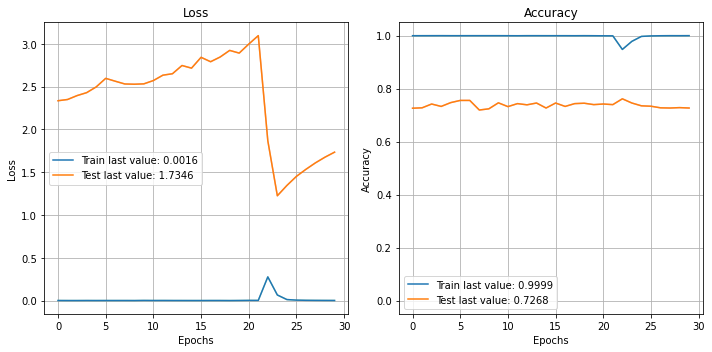

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

The accuracy of the lab4 model2 in this task is around 78%. 

##  Model 1-2: CNN or LSTM without pre-trained word embeddings

Please try one more model (CNN or LSTM) without pre-trained word embeddings in here:

In [ ]:
# Try CNN or LSTM without pre-trained word embeddings in here:

# LSTM model
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
input_layer = Input(shape=(128,))
embedding_layer = Embedding(mask_zero = False, input_length = 128, input_dim = 32575, output_dim = 100, embeddings_initializer='glorot_uniform')(input_layer)
lstm_layer = LSTM(100, return_sequences=False)(embedding_layer)
# pooling_layer = GlobalAveragePooling1DMasked()(lstm_layer)
hidden_dense_layer = Dense(16)(lstm_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model = Model(inputs= input_layer, outputs=output_dense_layer)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 100)          3257500   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,339,533
Trainable params: 3,339,533
Non-trainable params: 0
_________________________________________________________________


**<i> <font color ='darkblue'>We try the LSTM model by replacing the pooling layer from the previous model and check for improvement in model performance.</font></i>**

In [ ]:
# Model training
history = model.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 28s 746ms/step - loss: 0.5909 - accuracy: 0.7200 - val_loss: 0.5753 - val_accuracy: 0.7442
Epoch 2/30
35/35 [==============================] - 25s 717ms/step - loss: 0.5092 - accuracy: 0.7937 - val_loss: 0.5738 - val_accuracy: 0.7442
Epoch 3/30
35/35 [==============================] - 27s 759ms/step - loss: 0.5125 - accuracy: 0.7916 - val_loss: 0.5752 - val_accuracy: 0.7442
Epoch 4/30
35/35 [==============================] - 27s 765ms/step - loss: 0.5060 - accuracy: 0.7966 - val_loss: 0.5778 - val_accuracy: 0.7442
Epoch 5/30
35/35 [==============================] - 27s 763ms/step - loss: 0.5082 - accuracy: 0.7945 - val_loss: 0.5723 - val_accuracy: 0.7442
Epoch 6/30
35/35 [==============================] - 26s 750ms/step - loss: 0.5079 - accuracy: 0.7947 - val_loss: 0.5747 - val_accuracy: 0.7442
Epoch 7/30
35/35 [==============================] - 29s 829ms/step - loss: 0.5130 - accuracy: 0.7908 - val_loss: 0.5738 - val_accuracy: 0.7442

In [ ]:
# Model evaluation
results = model.evaluate(x_test_pad, y_test)

194/194 [==============================] - 5s 28ms/step - loss: 1.0595 - accuracy: 0.3982


In [ ]:
print(results)
# loss, accuracay 

[1.0594791173934937, 0.398221492767334]


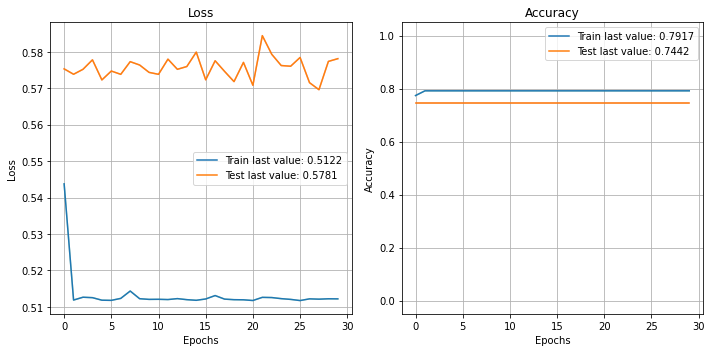

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

**<i> <font color ='darkblue'>We get very poor accuracy for our LSTM model on the test set hence, we now try the CNN model.</font></i>**

In [ ]:
# CNN model
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
input_layer = Input(shape=(128,))
embedding_layer = Embedding(mask_zero = False, input_length = 128, input_dim = 32575, output_dim = 100, embeddings_initializer='glorot_uniform')(input_layer)
cnn_layer = keras.layers.Conv1D(100, 6)(embedding_layer)
pooling_layer = GlobalAveragePooling1DMasked()(cnn_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model = Model(inputs= input_layer, outputs=output_dense_layer)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 100)          3257500   
_________________________________________________________________
conv1d (Conv1D)              (None, 123, 100)          60100     
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 3,319,233
Trainable params: 3,319,233
Non-trainable params: 0
_________________________________________________

**<i> <font color ='darkblue'>We implement the CNN model with 100 filters and 6 kernel size from the previous lab and modified the input and embedding layer to accomodate this case.</font></i>**

In [ ]:
# Model training
history = model.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 11s 302ms/step - loss: 0.5730 - accuracy: 0.7877 - val_loss: 0.5695 - val_accuracy: 0.7442
Epoch 2/30
35/35 [==============================] - 10s 298ms/step - loss: 0.4805 - accuracy: 0.7880 - val_loss: 0.4913 - val_accuracy: 0.7464
Epoch 3/30
35/35 [==============================] - 11s 305ms/step - loss: 0.3248 - accuracy: 0.8576 - val_loss: 0.4510 - val_accuracy: 0.7796
Epoch 4/30
35/35 [==============================] - 11s 304ms/step - loss: 0.2195 - accuracy: 0.9129 - val_loss: 0.4703 - val_accuracy: 0.7887
Epoch 5/30
35/35 [==============================] - 10s 300ms/step - loss: 0.1487 - accuracy: 0.9449 - val_loss: 0.5372 - val_accuracy: 0.7645
Epoch 6/30
35/35 [==============================] - 11s 304ms/step - loss: 0.1059 - accuracy: 0.9640 - val_loss: 0.6501 - val_accuracy: 0.7683
Epoch 7/30
35/35 [==============================] - 11s 305ms/step - loss: 0.0713 - accuracy: 0.9771 - val_loss: 0.7304 - val_accuracy: 0.7675

In [ ]:
results = model.evaluate(x_test_pad, y_test)

194/194 [==============================] - 1s 8ms/step - loss: 2.5686 - accuracy: 0.6859


In [ ]:
print(results)

[2.5685548782348633, 0.6858528852462769]


**<i> <font color ='darkblue'>Here, we can observe that the CNN model has achieved a better accuracy when compared with the LSTM model's performance on the test set.</font></i>**

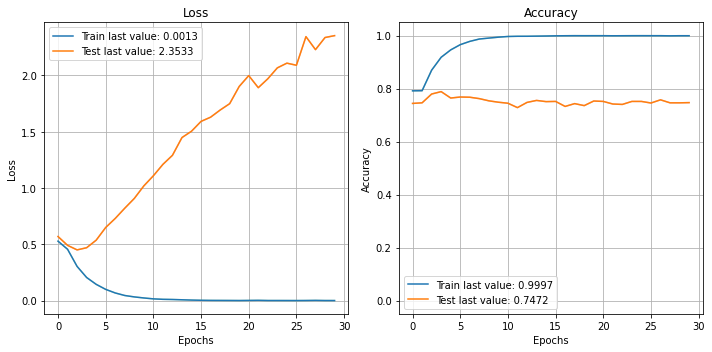

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

# Model 2: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2021-03-03 22:14:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-03 22:14:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-03 22:14:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


### Convert the data to GLOVE word index

The index in our vocabulary is different from that in GLOVE. For example, the word "you" corresponds to 394475 in GLOVE, while it corresponds to another index in our vocabulary. Thus we can not directly use the index data in the last section. We convert them from text tokens to GLOVE word index.

In [ ]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

394475
you
22261


In [ ]:
x_train_tweet_glove = []
x_train_topic_glove = []

for example in train_original:
  word_list_tweet = []
  word_list_topic = []
  for word in text_to_word_sequence(example[3]): 
    if word in wordToIndex.keys():
      word_list_tweet.append(wordToIndex[word])
    else:
      word_list_tweet.append(word_index["<UNK>"])
  x_train_tweet_glove.append(word_list_tweet)
  for word in text_to_word_sequence(example[1]):
    if word in wordToIndex.keys():
      word_list_topic.append(wordToIndex[word])
    else:
      word_list_topic.append(word_index["<UNK>"])
  x_train_topic_glove.append(word_list_topic)

x_dev_tweet_glove = []
x_dev_topic_glove = []

for example in dev_original:
  word_list_tweet = []
  word_list_topic = []
  for word in text_to_word_sequence(example[3]): 
    if word in wordToIndex.keys():
      word_list_tweet.append(wordToIndex[word])
    else:
      word_list_tweet.append(word_index["<UNK>"])
  x_dev_tweet_glove.append(word_list_tweet)
  for word in text_to_word_sequence(example[1]):
    if word in wordToIndex.keys():
      word_list_topic.append(wordToIndex[word])
    else:
      word_list_topic.append(word_index["<UNK>"])
  x_dev_topic_glove.append(word_list_topic)

x_test_tweet_glove = []
x_test_topic_glove = []

for example in test_original:
  word_list_tweet = []
  word_list_topic = []
  for word in text_to_word_sequence(example[3]): 
    if word in wordToIndex.keys():
      word_list_tweet.append(wordToIndex[word])
    else:
      word_list_tweet.append(word_index["<UNK>"])
  x_test_tweet_glove.append(word_list_tweet)
  for word in text_to_word_sequence(example[1]):
    if word in wordToIndex.keys():
      word_list_topic.append(wordToIndex[word])
    else:
      word_list_topic.append(word_index["<UNK>"])
  x_test_topic_glove.append(word_list_topic)

# You should get a print result like:
assert len(x_train_tweet_glove) == len(train_original)
assert len(x_train_topic_glove) == len(x_train_topic_int)
assert len(x_test_tweet_glove) == len(test_original)
assert len(x_test_topic_glove) == len(x_test_topic_int)
print("x_dev_tweet_glove[0]:")
print(x_dev_tweet_glove[0])
print("x_dev_topic_glove[0]:")
print(x_dev_topic_glove[0])

x_dev_tweet_glove[0]:
[196237, 395262, 198486, 190716, 388711, 264529, 365027, 360915, 242891, 194733, 196237, 395262, 57698, 198478, 190716, 269798, 319134, 54718, 182915, 350784, 103530, 2]
x_dev_topic_glove[0]:
[242891, 194733]


**<i> <font color ='darkblue'>
We performed similar partition of topics and tweets as before for each datatset(training set, development set and test set). This is done by considering corresponding columns, tokenising the string in those columns, and finding indexes from GloVe embeddings in wordToIndex corresponding to the tokens to create the two lists.
 </font></i>**

As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [ ]:
x_train_glove = []

for i in range(len(x_train_topic_glove)):
  innerList=[]
  for k in x_train_topic_glove[i]:
    innerList.append(k)
  innerList.append(word_index["<START>"])
  for j in x_train_tweet_glove[i]:
    innerList.append(j)
  x_train_glove.append(innerList)

x_dev_glove = []

for i in range(len(x_dev_topic_glove)):
  innerList=[]
  for k in x_dev_topic_glove[i]:
    innerList.append(k)
  innerList.append(word_index["<START>"])
  for j in x_dev_tweet_glove[i]:
    innerList.append(j)
  x_dev_glove.append(innerList)

x_test_glove = []

for i in range(len(x_test_topic_glove)):
  innerList=[]
  for k in x_test_topic_glove[i]:
    innerList.append(k)
  innerList.append(word_index["<START>"])
  for j in x_test_tweet_glove[i]:
    innerList.append(j)
  x_test_glove.append(innerList)

# Tips: 
# 1) There is no <START> token in GLOVE. Here we can use integer 1 to concatenate.
# 2) After combine them, do not foget to pad the sequences.


##### your code goes here:
x_train_pad_glove = np.array(keras.preprocessing.sequence.pad_sequences(x_train_glove, value=word_index["<PAD>"], padding='post', maxlen=128))

x_dev_pad_glove = np.array(keras.preprocessing.sequence.pad_sequences(x_dev_glove, value=word_index["<PAD>"], padding='post', maxlen=128))
                                                 
x_test_pad_glove = np.array(keras.preprocessing.sequence.pad_sequences(x_test_glove, value=word_index["<PAD>"], padding='post', maxlen=128))

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

Before paded:
[243317, 1, 118309, 243317, 357266, 2, 151349, 229153, 192973, 166369, 54718, 51582, 87775, 262350, 228306, 373375, 88558]
After paded:
[243317      1 118309 243317 357266      2 151349 229153 192973 166369
  54718  51582  87775 262350 228306 373375  88558      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      

**<i> <font color ='darkblue'> We concatenate list of indexes for topics and tweets similar to that in the previous sections and pad the resulting sequences.
 </font></i>**

## Model 2-1: Neural bag of words using pre-trained word embeddings

We use model3-1 in lab4 to deal with this task.

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
input_layer = Input(shape=(128,))
embedding_layer = embeddingLayer(input_layer)
pooling_layer = GlobalAveragePooling1DMasked()(embedding_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model3 = Model(inputs= input_layer, outputs=output_dense_layer)
model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 128, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
_________________________________________________________________


**<i> <font color ='darkblue'> Reusing the mentioned model from lab 4, we change the input shape to be 128 to match our current problem statement and input dimension is set to the length of GloVe corpus keeping rest of the configurations unchanged.
 </font></i>**

In [ ]:
# Model training
history = model3.fit(x_train_pad_glove,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/200
35/35 [==============================] - 2s 27ms/step - loss: 0.6151 - accuracy: 0.7884 - val_loss: 0.5734 - val_accuracy: 0.7442
Epoch 2/200
35/35 [==============================] - 1s 23ms/step - loss: 0.5103 - accuracy: 0.7925 - val_loss: 0.5697 - val_accuracy: 0.7442
Epoch 3/200
35/35 [==============================] - 1s 22ms/step - loss: 0.4957 - accuracy: 0.7924 - val_loss: 0.5532 - val_accuracy: 0.7442
Epoch 4/200
35/35 [==============================] - 1s 23ms/step - loss: 0.4786 - accuracy: 0.7953 - val_loss: 0.5384 - val_accuracy: 0.7442
Epoch 5/200
35/35 [==============================] - 1s 23ms/step - loss: 0.4609 - accuracy: 0.7970 - val_loss: 0.5202 - val_accuracy: 0.7442
Epoch 6/200
35/35 [==============================] - 1s 22ms/step - loss: 0.4502 - accuracy: 0.7970 - val_loss: 0.5039 - val_accuracy: 0.7442
Epoch 7/200
35/35 [==============================] - 1s 22ms/step - loss: 0.4331 - accuracy: 0.8037 - val_loss: 0.4844 - val_accuracy: 0.7457
Epoch 

In [ ]:
# Model evaluation
results = model3.evaluate(x_test_pad_glove, y_test)

194/194 [==============================] - 1s 3ms/step - loss: 0.4593 - accuracy: 0.7901


In [ ]:
print (results)

[0.45925137400627136, 0.7901374101638794]


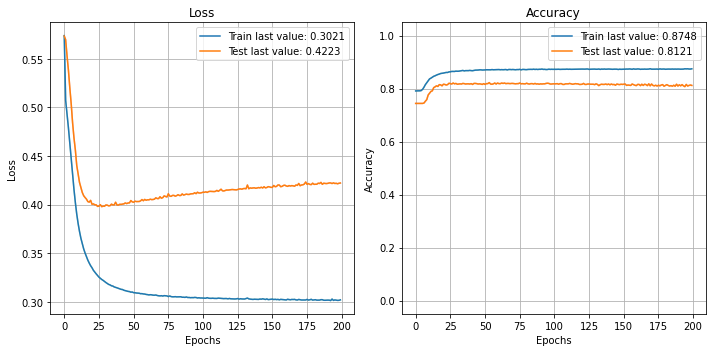

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

##  Model 2-2: CNN or LSTM with pre-trained word embeddings

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

In [ ]:
# Tips: Do not misuse the training data
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
input_layer = Input(shape=(128,))
embedding_layer = embeddingLayer(input_layer)
lstm_layer = LSTM(100, return_sequences=False)(embedding_layer)
hidden_dense_layer = Dense(16)(lstm_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model3 = Model(inputs= input_layer, outputs=output_dense_layer)
model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 128, 300)          120000300 
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 120,162,333
Trainable params: 162,033
Non-trainable params: 120,000,300
_________________________________________________________________


**<i> <font color ='darkblue'> We use the LSTM model consisting of the LSTM layer with 100 units replacing the pooling layer to our model to check its accuracy.
 </font></i>**

In [ ]:
# Model training
history = model3.fit(x_train_pad_glove,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 30s 814ms/step - loss: 0.6138 - accuracy: 0.7226 - val_loss: 0.5726 - val_accuracy: 0.7442
Epoch 2/50
35/35 [==============================] - 27s 785ms/step - loss: 0.5248 - accuracy: 0.7825 - val_loss: 0.5776 - val_accuracy: 0.7442
Epoch 3/50
35/35 [==============================] - 27s 773ms/step - loss: 0.5134 - accuracy: 0.7907 - val_loss: 0.5733 - val_accuracy: 0.7442
Epoch 4/50
35/35 [==============================] - 27s 781ms/step - loss: 0.5063 - accuracy: 0.7961 - val_loss: 0.5753 - val_accuracy: 0.7442
Epoch 5/50
35/35 [==============================] - 27s 785ms/step - loss: 0.5140 - accuracy: 0.7902 - val_loss: 0.5744 - val_accuracy: 0.7442
Epoch 6/50
35/35 [==============================] - 27s 783ms/step - loss: 0.5104 - accuracy: 0.7931 - val_loss: 0.5756 - val_accuracy: 0.7442
Epoch 7/50
35/35 [==============================] - 27s 778ms/step - loss: 0.5144 - accuracy: 0.7902 - val_loss: 0.5793 - val_accuracy: 0.7442

In [ ]:
# Model evaluation
results = model3.evaluate(x_test_pad_glove, y_test)

194/194 [==============================] - 7s 38ms/step - loss: 1.0335 - accuracy: 0.3982


In [ ]:
print (results)

[1.0334752798080444, 0.398221492767334]


**<i> <font color ='darkblue'>  LSTM model did not perform well on the test set and so, we move on to test the CNN model with pre-trained word embeddings.
 </font></i>**

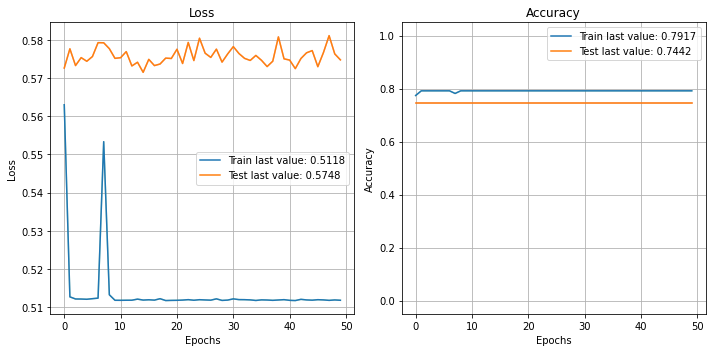

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

In [ ]:
# Tips: Do not misuse the training data
from keras.layers import Input, Embedding, Dense, LSTM, Lambda
from keras.models import Model
input_layer = Input(shape=(128,))
embedding_layer = embeddingLayer(input_layer)
cnn_layer = keras.layers.Conv1D(100, 6)(embedding_layer)
pooling_layer = GlobalAveragePooling1DMasked()(cnn_layer)
hidden_dense_layer = Dense(16)(pooling_layer)
output_dense_layer = Dense(1, activation='sigmoid')(hidden_dense_layer)
model3 = Model(inputs= input_layer, outputs=output_dense_layer)
model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 128, 300)          120000300 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 123, 100)          180100    
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 120,182,033
Trainable params: 181,733
Non-trainable params: 120,000,300
_______________________________________

In [ ]:
# Model training
history = model3.fit(x_train_pad_glove,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 21s 580ms/step - loss: 0.5336 - accuracy: 0.7824 - val_loss: 0.4869 - val_accuracy: 0.7494
Epoch 2/50
35/35 [==============================] - 20s 575ms/step - loss: 0.3947 - accuracy: 0.8307 - val_loss: 0.4126 - val_accuracy: 0.8008
Epoch 3/50
35/35 [==============================] - 20s 583ms/step - loss: 0.3358 - accuracy: 0.8604 - val_loss: 0.4058 - val_accuracy: 0.8189
Epoch 4/50
35/35 [==============================] - 20s 574ms/step - loss: 0.3298 - accuracy: 0.8640 - val_loss: 0.4020 - val_accuracy: 0.8174
Epoch 5/50
35/35 [==============================] - 20s 578ms/step - loss: 0.3213 - accuracy: 0.8673 - val_loss: 0.4046 - val_accuracy: 0.8174
Epoch 6/50
35/35 [==============================] - 21s 604ms/step - loss: 0.3172 - accuracy: 0.8665 - val_loss: 0.4012 - val_accuracy: 0.8136
Epoch 7/50
35/35 [==============================] - 20s 580ms/step - loss: 0.3109 - accuracy: 0.8699 - val_loss: 0.4151 - val_accuracy: 0.8106

In [ ]:
# Model evaluation
results = model3.evaluate(x_test_pad_glove, y_test)

194/194 [==============================] - 3s 17ms/step - loss: 0.4896 - accuracy: 0.7672


In [ ]:
print (results)

[0.4896109402179718, 0.7671786546707153]


**<i> <font color ='darkblue'>  CNN again outperforms LSTM model on the test set. </font></i>**

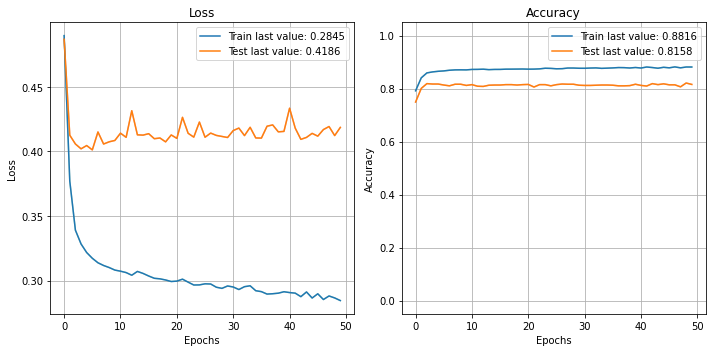

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

#  Model 3: Model with multiple-input

Model 1 and 2 are copied from lab4. We build new models in this section. 

In models 1 and 2, we combine the topics and tweets to input into the models. In model 3, we separately input these two data into the model and use different layers to analyze topics and tweets. 

In [ ]:
# First of all, pad the tweet and topic separately
x_train_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_tweet_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_tweet_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_tweet_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_train_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_topic_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=16)

x_dev_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_topic_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_test_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_topic_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)
print(x_dev_topic_pad_glove[0])

[242891 194733      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]


## Model 3-1 Neural bag of words model with multiple-input

# New Section

Model 3-1 needs you to modify the model 2-1 to be compatible with multiple-input.
You could find some tutorial examples from (https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/).

Please print the model summary and visualize it using vis_utils.

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embedding_layer_1 = embeddingLayer(input_layer_1)
pooling_layer_1 = GlobalAveragePooling1DMasked()(embedding_layer_1)
output_dense_layer_1 = Dense(16)(pooling_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
pooling_layer_2 = GlobalAveragePooling1DMasked()(embedding_layer_2)
output_dense_layer_2 = Dense(16)(pooling_layer_2)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
final_model.summary()
# model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
# model3.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_masked (None, 300)          0           GloVe_Embeddings[3][0]     

**<i> <font color ='darkblue'> So far, we have used used the concatenated list of indexes for topic and tweet, but now we will pass them as separate inputs to a set of different layers which later merge together before the output layer. As for passing the sequence for topics, input layer takes in the input of shape 16 corresponding to the maximum length of padded sequence of topics. This is followed by the GloVe embedding layer, and then the pooling layer and finally the dense layer. Similarly for tweets, the input layer takes in input of length equal to 128 after which there is an embedding layer, the pooling layer and then the dense layer.The output of both the dense layers is then concatenated and passed to the output layer as input to get the final output of the resulting network. Model architeccture can be seen below. 
 </font></i>**

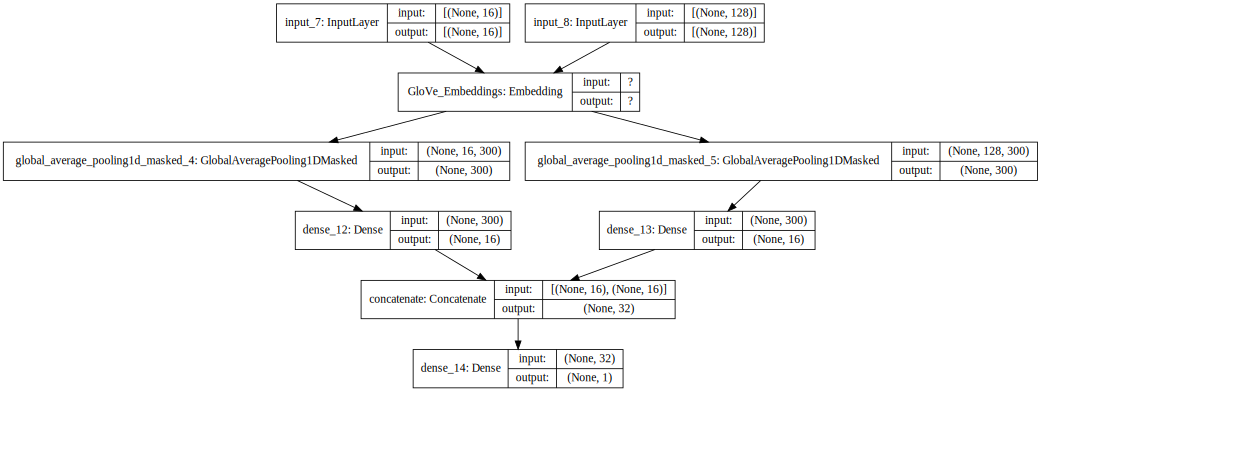

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(final_model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate your model:

In [ ]:
# Model training
history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/200
35/35 [==============================] - 1s 25ms/step - loss: 0.6348 - accuracy: 0.7520 - val_loss: 0.5686 - val_accuracy: 0.7442
Epoch 2/200
35/35 [==============================] - 1s 20ms/step - loss: 0.5066 - accuracy: 0.7846 - val_loss: 0.5466 - val_accuracy: 0.7442
Epoch 3/200
35/35 [==============================] - 1s 21ms/step - loss: 0.4602 - accuracy: 0.8023 - val_loss: 0.5195 - val_accuracy: 0.7442
Epoch 4/200
35/35 [==============================] - 1s 21ms/step - loss: 0.4397 - accuracy: 0.8078 - val_loss: 0.4962 - val_accuracy: 0.7442
Epoch 5/200
35/35 [==============================] - 1s 20ms/step - loss: 0.4240 - accuracy: 0.8175 - val_loss: 0.4791 - val_accuracy: 0.7426
Epoch 6/200
35/35 [==============================] - 1s 20ms/step - loss: 0.4062 - accuracy: 0.8288 - val_loss: 0.4665 - val_accuracy: 0.7411
Epoch 7/200
35/35 [==============================] - 1s 21ms/step - loss: 0.3956 - accuracy: 0.8364 - val_loss: 0.4568 - val_accuracy: 0.7434
Epoch 

In [ ]:
# Model evaluation
results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)

194/194 [==============================] - 1s 3ms/step - loss: 0.6787 - accuracy: 0.7174


In [ ]:
print (results)

[0.6787476539611816, 0.7173807621002197]


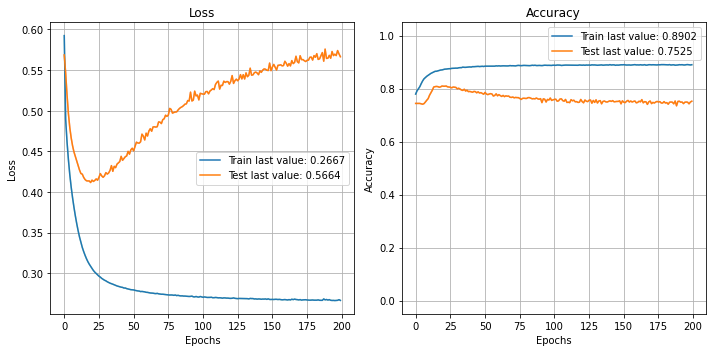

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

## Model 3-2 CNN or LSTM model with multiple-input

Modify the previous CNN or LSTM model to be compatible with multiple-input, similar to model 3-1. 

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embedding_layer_1 = embeddingLayer(input_layer_1)
lstm_layer_1 = LSTM(100, return_sequences=False)(embedding_layer_1)
output_dense_layer_1 = Dense(16)(lstm_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
lstm_layer_2 = LSTM(100, return_sequences=False)(embedding_layer_2)
output_dense_layer_2 = Dense(16)(lstm_layer_2)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
final_model.summary()



Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 100)          160400      GloVe_Embeddings[5][0]    

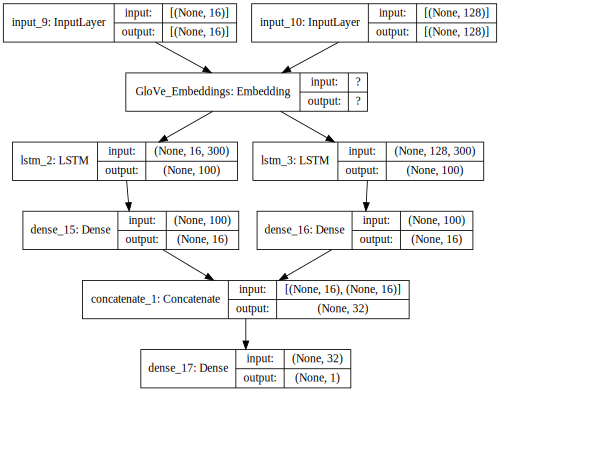

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(final_model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

**<i> <font color ='darkblue'> In this section, we try the multiple input model architecture with LSTM layers instead pooling layers and check the model accuracy.
 </font></i>**

In [ ]:
# Train and test the model
history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 33s 861ms/step - loss: 0.5741 - accuracy: 0.7510 - val_loss: 0.5174 - val_accuracy: 0.7358
Epoch 2/50
35/35 [==============================] - 30s 858ms/step - loss: 0.3711 - accuracy: 0.8441 - val_loss: 0.5268 - val_accuracy: 0.7592
Epoch 3/50
35/35 [==============================] - 30s 852ms/step - loss: 0.3608 - accuracy: 0.8495 - val_loss: 0.5270 - val_accuracy: 0.7457
Epoch 4/50
35/35 [==============================] - 30s 847ms/step - loss: 0.3644 - accuracy: 0.8475 - val_loss: 0.5528 - val_accuracy: 0.7457
Epoch 5/50
35/35 [==============================] - 29s 835ms/step - loss: 0.3620 - accuracy: 0.8470 - val_loss: 0.5266 - val_accuracy: 0.7457
Epoch 6/50
35/35 [==============================] - 30s 843ms/step - loss: 0.3595 - accuracy: 0.8509 - val_loss: 0.5467 - val_accuracy: 0.7592
Epoch 7/50
35/35 [==============================] - 29s 838ms/step - loss: 0.3594 - accuracy: 0.8479 - val_loss: 0.5203 - val_accuracy: 0.7592

In [ ]:
results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)

194/194 [==============================] - 7s 38ms/step - loss: 0.8040 - accuracy: 0.6003


In [ ]:
print (results)

[0.8039522767066956, 0.6003233790397644]


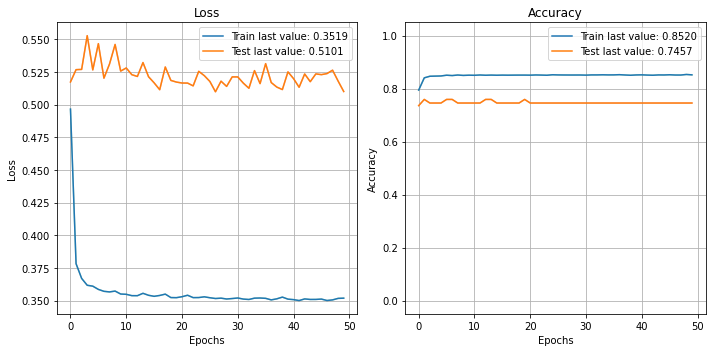

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

**<i> <font color ='darkblue'> We check if the multiple input model architecture with convolution layer performs better than this LSTM model.
 </font></i>**

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embedding_layer_1 = embeddingLayer(input_layer_1)
cnn_layer_1 = keras.layers.Conv1D(100, 6)(embedding_layer_1)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_1)
output_dense_layer_1 = Dense(16)(pooling_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
cnn_layer_2 = keras.layers.Conv1D(100, 6)(embedding_layer_2)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_2)
output_dense_layer_2 = Dense(16)(pooling_layer_1)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
final_model.summary()


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 11, 100)      180100      GloVe_Embeddings[7][0]    

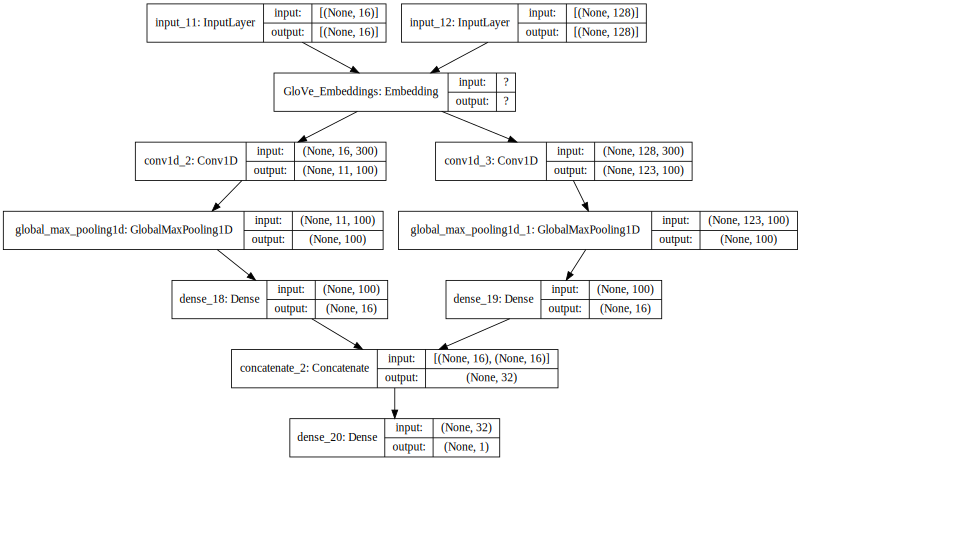

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(final_model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [ ]:
# Model training
history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 23s 651ms/step - loss: 0.4471 - accuracy: 0.8216 - val_loss: 0.3991 - val_accuracy: 0.8083
Epoch 2/50
35/35 [==============================] - 22s 637ms/step - loss: 0.2828 - accuracy: 0.8802 - val_loss: 0.3702 - val_accuracy: 0.8325
Epoch 3/50
35/35 [==============================] - 22s 635ms/step - loss: 0.2322 - accuracy: 0.9079 - val_loss: 0.3595 - val_accuracy: 0.8370
Epoch 4/50
35/35 [==============================] - 22s 631ms/step - loss: 0.1916 - accuracy: 0.9274 - val_loss: 0.3788 - val_accuracy: 0.8332
Epoch 5/50
35/35 [==============================] - 22s 632ms/step - loss: 0.1416 - accuracy: 0.9535 - val_loss: 0.4020 - val_accuracy: 0.8091
Epoch 6/50
35/35 [==============================] - 22s 630ms/step - loss: 0.0964 - accuracy: 0.9736 - val_loss: 0.4154 - val_accuracy: 0.8196
Epoch 7/50
35/35 [==============================] - 22s 635ms/step - loss: 0.0533 - accuracy: 0.9931 - val_loss: 0.4642 - val_accuracy: 0.8211

In [ ]:
# Model evaluation
results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)

194/194 [==============================] - 4s 19ms/step - loss: 0.9615 - accuracy: 0.8032


In [ ]:
print (results)

[0.9614887237548828, 0.8032336235046387]


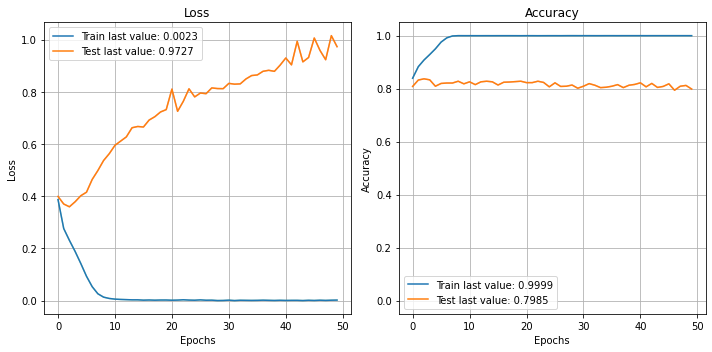

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()

**<i> <font color ='darkblue'> We now try to enhance the model's performance by changing the optimizer and loss function.
 </font></i>**

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embedding_layer_1 = embeddingLayer(input_layer_1)
cnn_layer_1 = keras.layers.Conv1D(100, 6)(embedding_layer_1)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_1)
output_dense_layer_1 = Dense(16)(pooling_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
cnn_layer_2 = keras.layers.Conv1D(100, 6)(embedding_layer_2)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_2)
output_dense_layer_2 = Dense(16)(pooling_layer_1)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('rmsprop', 'mse', metrics=['accuracy'])
final_model.summary()


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 11, 100)      180100      GloVe_Embeddings[9][0]    

In [ ]:
# Train and test the model
history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 24s 672ms/step - loss: 0.1608 - accuracy: 0.7989 - val_loss: 0.1654 - val_accuracy: 0.7728
Epoch 2/50
35/35 [==============================] - 22s 640ms/step - loss: 0.0953 - accuracy: 0.8730 - val_loss: 0.1457 - val_accuracy: 0.7857
Epoch 3/50
35/35 [==============================] - 22s 642ms/step - loss: 0.0819 - accuracy: 0.8915 - val_loss: 0.1563 - val_accuracy: 0.7887
Epoch 4/50
35/35 [==============================] - 22s 636ms/step - loss: 0.0710 - accuracy: 0.9084 - val_loss: 0.1278 - val_accuracy: 0.8113
Epoch 5/50
35/35 [==============================] - 22s 639ms/step - loss: 0.0625 - accuracy: 0.9187 - val_loss: 0.1516 - val_accuracy: 0.7962
Epoch 6/50
35/35 [==============================] - 22s 643ms/step - loss: 0.0552 - accuracy: 0.9327 - val_loss: 0.1408 - val_accuracy: 0.8053
Epoch 7/50
35/35 [==============================] - 23s 644ms/step - loss: 0.0499 - accuracy: 0.9385 - val_loss: 0.1421 - val_accuracy: 0.7985

In [ ]:
results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)

194/194 [==============================] - 4s 19ms/step - loss: 0.1635 - accuracy: 0.8034


In [ ]:
print (results)

[0.16349175572395325, 0.8033953309059143]


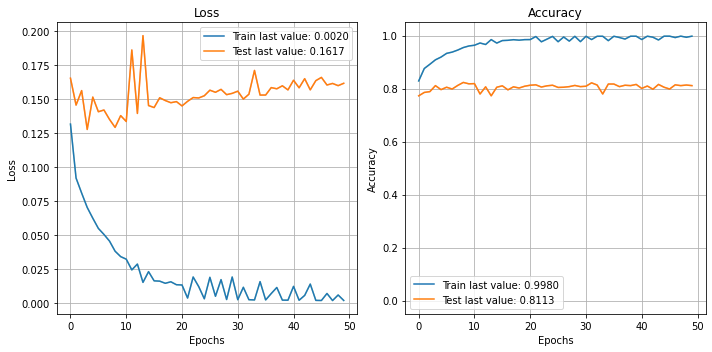

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()


**<i> <font color ='darkblue'> Trying deeper CNN
 </font></i>**



In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embedding_layer_1 = embeddingLayer(input_layer_1)
cnn_layer_1 = keras.layers.Conv1D(100, 6)(embedding_layer_1)
cnn_layer_2 = keras.layers.Conv1D(100, 6)(cnn_layer_1)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_2)
output_dense_layer_1 = Dense(16)(pooling_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
cnn_layer_3 = keras.layers.Conv1D(100, 6)(embedding_layer_2)
cnn_layer_4 = keras.layers.Conv1D(100, 6)(cnn_layer_3)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_4)
output_dense_layer_2 = Dense(16)(pooling_layer_1)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('rmsprop', 'mse', metrics=['accuracy'])
final_model.summary()


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 11, 100)      180100      GloVe_Embeddings[11][0]   

In [ ]:
# Model training 

history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 32s 886ms/step - loss: 0.2258 - accuracy: 0.7060 - val_loss: 0.1434 - val_accuracy: 0.7842
Epoch 2/50
35/35 [==============================] - 31s 882ms/step - loss: 0.1126 - accuracy: 0.8522 - val_loss: 0.1408 - val_accuracy: 0.8060
Epoch 3/50
35/35 [==============================] - 31s 875ms/step - loss: 0.0925 - accuracy: 0.8820 - val_loss: 0.1300 - val_accuracy: 0.8053
Epoch 4/50
35/35 [==============================] - 31s 884ms/step - loss: 0.0781 - accuracy: 0.8983 - val_loss: 0.1226 - val_accuracy: 0.8219
Epoch 5/50
35/35 [==============================] - 31s 875ms/step - loss: 0.0668 - accuracy: 0.9152 - val_loss: 0.1309 - val_accuracy: 0.7985
Epoch 6/50
35/35 [==============================] - 31s 881ms/step - loss: 0.0550 - accuracy: 0.9346 - val_loss: 0.1494 - val_accuracy: 0.7819
Epoch 7/50
35/35 [==============================] - 31s 884ms/step - loss: 0.0453 - accuracy: 0.9488 - val_loss: 0.1410 - val_accuracy: 0.7872

In [ ]:
# Model evaluation

results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results)

194/194 [==============================] - 5s 24ms/step - loss: 0.1921 - accuracy: 0.7657
[0.19214408099651337, 0.7657235264778137]



**<i> <font color ='darkblue'> Trying deeper LSTM
 </font></i>**



In [ ]:
# Deeper LSTM

from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embedding_layer_1 = embeddingLayer(input_layer_1)
lstm_layer_1 = LSTM(100, return_sequences=False)(embedding_layer_1)
dense_layer_1 = Dense(16)(lstm_layer_1)
output_dense_layer_1 = Dense(16)(dense_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
lstm_layer_2 = LSTM(100, return_sequences=False)(embedding_layer_2)
dense_layer_2 = Dense(16)(lstm_layer_2)
output_dense_layer_2 = Dense(16)(dense_layer_2)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
final_model.summary()




Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 100)          160400      GloVe_Embeddings[14][0]   

In [ ]:
# Model training 

history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 33s 858ms/step - loss: 0.5751 - accuracy: 0.7592 - val_loss: 0.4650 - val_accuracy: 0.7706
Epoch 2/50
35/35 [==============================] - 29s 839ms/step - loss: 0.3844 - accuracy: 0.8442 - val_loss: 0.4898 - val_accuracy: 0.7857
Epoch 3/50
35/35 [==============================] - 29s 837ms/step - loss: 0.3800 - accuracy: 0.8405 - val_loss: 0.5005 - val_accuracy: 0.7457
Epoch 4/50
35/35 [==============================] - 30s 846ms/step - loss: 0.3590 - accuracy: 0.8537 - val_loss: 0.4970 - val_accuracy: 0.7592
Epoch 5/50
35/35 [==============================] - 30s 867ms/step - loss: 0.3625 - accuracy: 0.8504 - val_loss: 0.4992 - val_accuracy: 0.7857
Epoch 6/50
35/35 [==============================] - 30s 847ms/step - loss: 0.3619 - accuracy: 0.8495 - val_loss: 0.5029 - val_accuracy: 0.7857
Epoch 7/50
35/35 [==============================] - 30s 847ms/step - loss: 0.3562 - accuracy: 0.8550 - val_loss: 0.5052 - val_accuracy: 0.7457

In [ ]:
# Model evaluation

results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results)

194/194 [==============================] - 8s 40ms/step - loss: 0.8147 - accuracy: 0.6129
[0.814711332321167, 0.6129345297813416]



**<i> <font color ='darkblue'> Trying bi-directional LSTM
 </font></i>**

In [ ]:
# Bi-directional LSTM

from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embedding_layer_1 = embeddingLayer(input_layer_1)
lstm_layer_1 = Bidirectional(LSTM(100, return_sequences=False))(embedding_layer_1)
output_dense_layer_1 = Dense(16)(lstm_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
lstm_layer_2 = Bidirectional(LSTM(100, return_sequences=False))(embedding_layer_2)
output_dense_layer_2 = Dense(16)(lstm_layer_2)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
final_model.summary()



Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200)          320800      GloVe_Embeddings[16][0]   

In [ ]:
# Model training 

history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 60s 2s/step - loss: 0.4811 - accuracy: 0.8007 - val_loss: 0.4499 - val_accuracy: 0.7683
Epoch 2/50
35/35 [==============================] - 53s 2s/step - loss: 0.3254 - accuracy: 0.8642 - val_loss: 0.3936 - val_accuracy: 0.8249
Epoch 3/50
35/35 [==============================] - 53s 2s/step - loss: 0.2744 - accuracy: 0.8856 - val_loss: 0.4074 - val_accuracy: 0.8045
Epoch 4/50
35/35 [==============================] - 52s 1s/step - loss: 0.2565 - accuracy: 0.8940 - val_loss: 0.4039 - val_accuracy: 0.8121
Epoch 5/50
35/35 [==============================] - 52s 1s/step - loss: 0.2472 - accuracy: 0.8975 - val_loss: 0.4002 - val_accuracy: 0.8196
Epoch 6/50
35/35 [==============================] - 53s 2s/step - loss: 0.2379 - accuracy: 0.9029 - val_loss: 0.4112 - val_accuracy: 0.8136
Epoch 7/50
35/35 [==============================] - 52s 1s/step - loss: 0.2297 - accuracy: 0.9049 - val_loss: 0.4085 - val_accuracy: 0.8234
Epoch 8/50
35/35 [==

In [ ]:
# Model evaluation

results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results)

194/194 [==============================] - 13s 66ms/step - loss: 2.1908 - accuracy: 0.7740
[2.1908164024353027, 0.773969292640686]



**<i> <font color ='darkblue'> Trying CNN with fine-tuned embeddings
 </font></i>**



In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)
embedding_layer_1 = embeddingLayer(input_layer_1)
cnn_layer_1 = keras.layers.Conv1D(100, 6)(embedding_layer_1)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_1)
output_dense_layer_1 = Dense(16)(pooling_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
cnn_layer_2 = keras.layers.Conv1D(100, 6)(embedding_layer_2)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_2)
output_dense_layer_2 = Dense(16)(pooling_layer_1)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
final_model.summary()


Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 11, 100)      180100      GloVe_Embeddings[0][0]    

In [ ]:
# Model training 

history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 62s 2s/step - loss: 0.7903 - accuracy: 0.6947 - val_loss: 0.4291 - val_accuracy: 0.8015
Epoch 2/50
35/35 [==============================] - 61s 2s/step - loss: 0.3020 - accuracy: 0.8744 - val_loss: 0.3982 - val_accuracy: 0.8136
Epoch 3/50
35/35 [==============================] - 61s 2s/step - loss: 0.2349 - accuracy: 0.9063 - val_loss: 0.3827 - val_accuracy: 0.8181
Epoch 4/50
35/35 [==============================] - 60s 2s/step - loss: 0.1904 - accuracy: 0.9308 - val_loss: 0.3839 - val_accuracy: 0.8143
Epoch 5/50
35/35 [==============================] - 60s 2s/step - loss: 0.1426 - accuracy: 0.9501 - val_loss: 0.3973 - val_accuracy: 0.8113
Epoch 6/50
35/35 [==============================] - 60s 2s/step - loss: 0.1012 - accuracy: 0.9719 - val_loss: 0.4274 - val_accuracy: 0.8068
Epoch 7/50
35/35 [==============================] - 61s 2s/step - loss: 0.0692 - accuracy: 0.9870 - val_loss: 0.4525 - val_accuracy: 0.8068
Epoch 8/50
35/35 [==

In [ ]:
# Model evaluation

results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results)

194/194 [==============================] - 4s 18ms/step - loss: 0.9157 - accuracy: 0.8103
[0.9157285094261169, 0.8103476166725159]



**<i> <font color ='darkblue'> Trying deeper CNN with fine-tuned embeddings
 </font></i>**



In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)
embedding_layer_1 = embeddingLayer(input_layer_1)
cnn_layer_1 = keras.layers.Conv1D(100, 6)(embedding_layer_1)
cnn_layer_2 = keras.layers.Conv1D(100, 6)(cnn_layer_1)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_2)
output_dense_layer_1 = Dense(16)(pooling_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
cnn_layer_3 = keras.layers.Conv1D(100, 6)(embedding_layer_2)
cnn_layer_4 = keras.layers.Conv1D(100, 6)(cnn_layer_3)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_4)
output_dense_layer_2 = Dense(16)(pooling_layer_1)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('rmsprop', 'mse', metrics=['accuracy'])
final_model.summary()


Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 11, 100)      180100      GloVe_Embeddings[0][0]    

In [ ]:
# Model training 

history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 57s 2s/step - loss: 0.1759 - accuracy: 0.7777 - val_loss: 0.1437 - val_accuracy: 0.7691
Epoch 2/50
35/35 [==============================] - 55s 2s/step - loss: 0.0941 - accuracy: 0.8727 - val_loss: 0.1389 - val_accuracy: 0.8083
Epoch 3/50
35/35 [==============================] - 55s 2s/step - loss: 0.0704 - accuracy: 0.9112 - val_loss: 0.1249 - val_accuracy: 0.8226
Epoch 4/50
35/35 [==============================] - 55s 2s/step - loss: 0.0563 - accuracy: 0.9299 - val_loss: 0.1336 - val_accuracy: 0.8000
Epoch 5/50
35/35 [==============================] - 55s 2s/step - loss: 0.0394 - accuracy: 0.9558 - val_loss: 0.1360 - val_accuracy: 0.8045
Epoch 6/50
35/35 [==============================] - 54s 2s/step - loss: 0.0280 - accuracy: 0.9706 - val_loss: 0.1480 - val_accuracy: 0.7947
Epoch 7/50
35/35 [==============================] - 54s 2s/step - loss: 0.0180 - accuracy: 0.9834 - val_loss: 0.1591 - val_accuracy: 0.7789
Epoch 8/50
35/35 [==

In [ ]:
# Model evaluation

results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results)

194/194 [==============================] - 5s 23ms/step - loss: 0.1714 - accuracy: 0.8016
[0.1713651865720749, 0.8016167879104614]



**<i> <font color ='darkblue'> Trying deeper CNN with fine-tuned embeddings and dropout layer
 </font></i>**

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Lambda, concatenate, Dropout
from keras.models import Model
input_layer_1 = Input(shape=(16,))
input_layer_2 = Input(shape=(128,))
#First Input
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)
embedding_layer_1 = embeddingLayer(input_layer_1)
dropout_layer_1 = Dropout(rate=0.2)(embedding_layer_1)
cnn_layer_1 = keras.layers.Conv1D(100, 6)(dropout_layer_1)
cnn_layer_2 = keras.layers.Conv1D(100, 6)(cnn_layer_1)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_2)
output_dense_layer_1 = Dense(16)(pooling_layer_1)
model_1 = Model(inputs= input_layer_1, outputs=output_dense_layer_1)
#Second Input
embedding_layer_2 = embeddingLayer(input_layer_2)
dropout_layer_2 = Dropout(rate=0.2)(embedding_layer_2)
cnn_layer_3 = keras.layers.Conv1D(100, 6)(dropout_layer_2)
cnn_layer_4 = keras.layers.Conv1D(100, 6)(cnn_layer_3)
pooling_layer_1 = GlobalMaxPooling1D()(cnn_layer_4)
output_dense_layer_2 = Dense(16)(pooling_layer_1)
model_2 = Model(inputs= input_layer_2, outputs=output_dense_layer_2)

combined_layer = concatenate([model_1.output, model_2.output])

output_dense_layer = Dense(1, activation='sigmoid')(combined_layer)

final_model = Model(inputs=[model_1.input, model_2.input], outputs = output_dense_layer)
final_model.compile('rmsprop', 'mse', metrics=['accuracy'])
final_model.summary()


Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16, 300)      0           GloVe_Embeddings[0][0]    

In [ ]:
# Model training 

history = final_model.fit(x = [x_train_topic_pad_glove, x_train_tweet_pad_glove],
                    y = y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev),
                    verbose=1)

Epoch 1/50
35/35 [==============================] - 60s 2s/step - loss: 0.2221 - accuracy: 0.7620 - val_loss: 0.2505 - val_accuracy: 0.7442
Epoch 2/50
35/35 [==============================] - 58s 2s/step - loss: 0.1416 - accuracy: 0.8352 - val_loss: 0.1418 - val_accuracy: 0.7902
Epoch 3/50
35/35 [==============================] - 58s 2s/step - loss: 0.0992 - accuracy: 0.8674 - val_loss: 0.1278 - val_accuracy: 0.8242
Epoch 4/50
35/35 [==============================] - 58s 2s/step - loss: 0.0851 - accuracy: 0.8890 - val_loss: 0.1246 - val_accuracy: 0.8219
Epoch 5/50
35/35 [==============================] - 59s 2s/step - loss: 0.0704 - accuracy: 0.9065 - val_loss: 0.1213 - val_accuracy: 0.8272
Epoch 6/50
35/35 [==============================] - 59s 2s/step - loss: 0.0580 - accuracy: 0.9276 - val_loss: 0.1470 - val_accuracy: 0.7977
Epoch 7/50
35/35 [==============================] - 58s 2s/step - loss: 0.0498 - accuracy: 0.9367 - val_loss: 0.1276 - val_accuracy: 0.8302
Epoch 8/50
35/35 [==

In [ ]:
# Model evaluation

results = final_model.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results)

194/194 [==============================] - 5s 23ms/step - loss: 0.1867 - accuracy: 0.7856
[0.18672232329845428, 0.7856103181838989]



**<i> <font color ='darkblue'> In this section, to get an accuracy of 81% and above, we tried different different versions of LSTM and CNNs, made deeper networks, customized pre-trained GloVe embeddings, added dropout layer, and experimented with loss function and optimizers. By far, only the CNN model with fine-tuned embeddings could achieve an accuracy of about 81% on the test set nearly followed by a version of CNN with MSE loss and deeper CNN with fine-tuned embeddings both achieving 80% accuracy. It can hence be determined CNN models work well for sentiment analysis problem especially when we need to model word subsequences like topic. Also, fine-tuning word embeddings make the model better accustomed to the problem domain thereby enhancing the model performance. Other changes do contribute to minor improvements in performance.
 </font></i>**